In [1]:
import numpy as np
import pickle
from scipy.stats import pearsonr
from scipy.stats import skew
import sys
from sklearn.metrics.pairwise import pairwise_distances
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

sys.path.append('../')
import scripts.outliers as outliers
import scripts.utils_spatial as utils_spatial
import scripts.utils as utils

In [3]:
X_list, Y, Yaudio = pickle.load(open('../data/lda_data_melodia_8.pickle','rb'))
#ddf = outliers.load_metadata(Yaudio, metadata_file='../data/metadata.csv')
#w, data_countries = utils_spatial.get_neighbors_for_countries_in_dataset(Y)
#w_dict = utils_spatial.from_weights_to_dict(w, data_countries)
X = np.concatenate(X_list, axis=1)

# global outliers
#df_global, threshold, MD = outliers.get_outliers_df(X, Y, chi2thr=0.999)

In [4]:
X.shape

(8200, 380)

## distance matrix

In [4]:
D = pairwise_distances(X, metric='mahalanobis')

In [5]:
np.savetxt('../data/D_mahal.csv', D)
D = np.loadtxt('../data/D_mahal.csv')
D.shape

(8200, 8200)

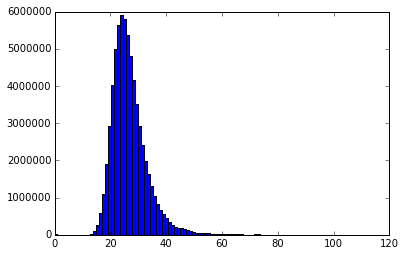

In [6]:
plt.hist(D.ravel(), bins=100);

## n-occurrence and stats

In [9]:
def n_occurrence_from_D(D, k=10, n_items=None):
    if n_items is None:
        n_items = len(D)
    sort_idx = np.argsort(D, axis=1)
    D_k = sort_idx[:, 1:(k+1)]  # nearest neighbour is the item itself
    N_k = np.bincount(D_k.astype(int).ravel(), minlength=n_items)
    return N_k

60
10.0869227031
0.0
60.0
389.813680947
142
7.70305908648


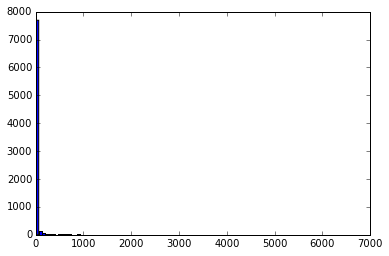

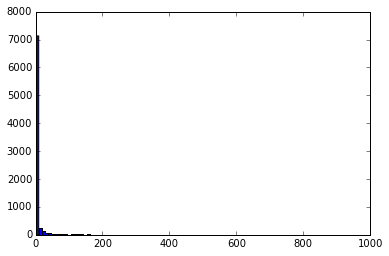

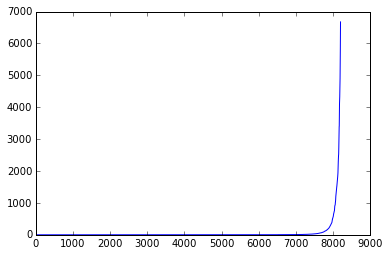

In [14]:
# take k mean of country sample
uniq_countries, uniq_counts = np.unique(Y, return_counts=True)
k = np.int(np.round(np.mean(uniq_counts)))
#N_k = n_occurrence_from_D(D, k=k)

print k
print skew(N_k)
print np.median(N_k)
print np.mean(N_k)
print np.std(N_k)
print len(np.where(N_k>1000)[0])
print skew(N_k[N_k<1000])

plt.figure()
plt.hist(N_k, bins=100);
plt.figure()
plt.hist(N_k[N_k<1000], bins=100);
plt.figure()
plt.plot(np.sort(N_k))

In [16]:
sort_idx = np.argsort(D, axis=1)
k = 100
D_k = sort_idx[:, 1:(k+1)]

In [17]:
D_k

array([[4650, 2942, 3520, ..., 3488, 2864, 6361],
       [1933, 6143, 6757, ..., 2346, 3441, 6857],
       [3170, 2549, 4860, ..., 2260, 2978, 7433],
       ..., 
       [6016, 2243, 1616, ..., 3486, 3441, 4554],
       [7027, 4860, 6346, ..., 7312, 6972, 5532],
       [5119, 1563, 4035, ..., 6253, 7433, 3232]])

In [12]:
large_hubs_idx = np.where(N_k>1000)[0]
print large_hubs_idx
print Y[large_hubs_idx]
print Yaudio[large_hubs_idx]

[ 129  186  261  373  432  468  509  515  552  562  627  655  701  710  740
  743  861  913  997 1012 1064 1128 1204 1273 1422 1426 1563 1566 1622 1761
 1846 1933 1936 1949 1980 1989 2034 2042 2053 2110 2147 2329 2335 2346 2462
 2546 2549 2568 2651 2864 2903 3003 3044 3069 3170 3215 3239 3295 3383 3397
 3441 3486 3488 3517 3520 3686 3712 3731 3859 3892 3982 4026 4035 4167 4208
 4390 4421 4456 4549 4554 4571 4639 4650 4782 4822 4859 4860 4869 4940 5020
 5042 5091 5119 5146 5189 5352 5432 5458 5493 5532 5707 5873 5894 5914 5926
 5961 6056 6123 6143 6160 6242 6253 6346 6356 6439 6476 6487 6678 6819 6857
 6859 6876 7027 7051 7053 7091 7312 7333 7361 7464 7478 7617 7627 7678 7783
 7849 7884 7888 7891 7920 8035 8106]
['India' 'Kazakhstan' 'Lesotho' 'Somalia' 'Kazakhstan' 'Kazakhstan'
 'Kazakhstan' 'Nigeria' 'South Sudan' 'South Sudan' 'Nigeria' 'Kazakhstan'
 'Nigeria' 'Kazakhstan' 'Kazakhstan' 'Kazakhstan' 'United Kingdom'
 'South Sudan' 'Uganda' 'Solomon Islands' 'United States of America'


In [21]:
np.where(D_k==515)[0].shape

(7160,)

## let's get the audio url to listen to tracks identified as large hubs

In [12]:
ddf = outliers.load_metadata(Yaudio, metadata_file='../data/metadata_BLSM_language_all.csv')
#ddf = outliers.load_metadata(Yaudio, metadata_file='/Users/mariapanteli/Documents/'+
#                             'QMUL/Code/MyPythonCode/MergeBL-Smith/data/metadata_BLSM_language_all.csv')

/homes/mp305/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (0,1,2,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21,22,23,24,25,26,27,29,31,35,38,39,40,41,44,45,48,55,56,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,93,95,96) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [6]:
ddf.shape

(8200, 108)

In [7]:
"songurls_Album" in ddf.columns

True

### first, fix the url for BL tracks (because it was changed recently and the metadata.csv file is not updated) 

In [14]:
bl_inds = np.where(np.isnan(ddf['BuyLinkTrackDownload']))[0]
for bl_ind in bl_inds:
    ddf['songurls_Album'].iloc[bl_ind] = ('https://sounds.bl.uk/World-and-traditional-music/' + 
                                        ddf['Folder'].iloc[bl_ind] + '/' + 
                                        ddf['MetaFile'].iloc[bl_ind].split('.')[0])

/homes/mp305/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
large_hubs_idx = np.array([515, 2549, 3486, 5020, 5119])
ddf['songurls_Album'].iloc[large_hubs_idx].get_values()

array([ 'https://sounds.bl.uk/World-and-traditional-music/Decca-West-African-recordings/025M-1CS0043663XX-0100V0',
       'https://sounds.bl.uk/World-and-traditional-music/Rycroft/025M-C0811X0005XX-2000V0',
       'https://sounds.bl.uk/World-and-traditional-music/Colin-Huehns-Pakistan/025M-C0485X0085XX-3100V0',
       'https://sounds.bl.uk/World-and-traditional-music/Rycroft/025M-C0811X0005XX-1300V0',
       'https://sounds.bl.uk/World-and-traditional-music/Colin-Huehns-Pakistan/025M-C0485X0031XX-0500V0'], dtype=object)

## what if we use a different distance metric?

1.20652171267


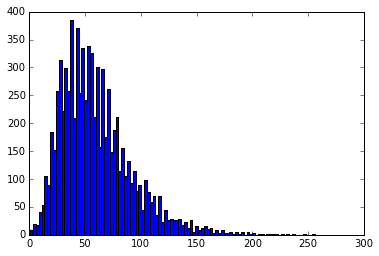

In [7]:
D_cos = pairwise_distances(X, metric='cosine')
uniq_countries, uniq_counts = np.unique(Y, return_counts=True)
k = np.int(np.round(np.mean(uniq_counts)))
N_k = n_occurrence_from_D(D_cos, k=k)
print skew(N_k)
plt.figure()
plt.hist(N_k, bins=100);

## are the extreme hubs same as before?

In [15]:
sort_idx = np.argsort(N_k)
print N_k[sort_idx[-5:]], ddf['songurls_Album'].iloc[sort_idx[-5:]].get_values()

[232 233 238 246 256] [ 'https://sounds.bl.uk/World-and-traditional-music/Dinka-songs-from-South-Sudan/025M-C1580X0004XX-0001V0'
 'https://sounds.bl.uk/World-and-traditional-music/Dinka-songs-from-South-Sudan/025M-C1580X0109XX-0001V0'
 'https://sounds.bl.uk/World-and-traditional-music/Terry-Yarnell-Collection/025M-C1005X0002XX-1200V0'
 'https://sounds.bl.uk/World-and-traditional-music/Roy-Palmer-collection/025M-C1023X0006XX-0700V0'
 'https://sounds.bl.uk/World-and-traditional-music/Terry-Yarnell-Collection/025M-C1005X0004XX-1900V0']


## pairwise Mahalanobis seems to have extreme values, how about Mahalanobis from the whole set?

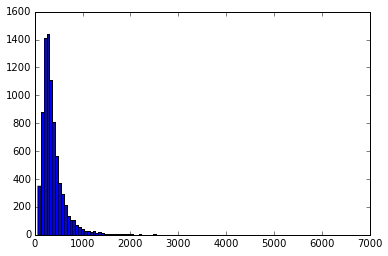

In [6]:
threshold, y_pred, MD = utils.get_outliers_Mahal(X, chi2thr=0.999)
plt.figure()
plt.hist(MD, bins=100);

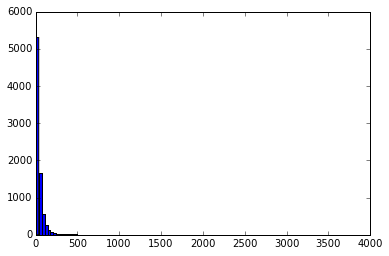

In [7]:
threshold, y_pred, MD = utils.get_outliers_Mahal(X[:, :50], chi2thr=0.999)
plt.figure()
plt.hist(MD, bins=100);